Goals of this notebook
---
* Show that DeePC can be equivalently recast in the indirect form (23)
* Discuss the problems in  low-data regimes

On the equivalence of direct and indirect data-driven predictive control approaches   
_Per Mattsson, Fabio Bonassi, Valentina Breschi, Thomas B. Schön_  
Pre-print, 2024. [arXiv: 2403.05860](https://arxiv.org/abs/2403.05860)

#### A) Case $\Sigma_\varphi$ invertible
If $N > (n_u + n_y) \rho + n_u T$, i.e. $\bar{N} > (n_u + n_y + 1) \rho + (n_u + 1) T - 1$, $\Sigma_\varphi$ is invertible with high probability (provided that the input is persistently exciting and the system is subject to measurement noise).

In this case, the range constraint $\varphi \in \mathcal{R}(\Sigma_\varphi)$ can be removed.

#### B) Case $\Sigma_\varphi$ not invertible
If $N < (n_u + n_y) \rho + n_u T$, the matrix $\Sigma_\varphi$ becomes singular. The range constraint $\varphi \in \mathcal{R}(\Sigma_\varphi)$ needs to be enforced.

#### C) Extremely-low data regimes (Remark 3)
The range constraint is equivalent to imposing that $\exists c$ such  that
$$\varphi = \begin{bmatrix} \pmb{z} \\ \pmb{u} \end{bmatrix} = \underbrace{\begin{bmatrix} \Sigma_{\varphi, z} \\ \hline \Sigma_{\varphi, u} \end{bmatrix}}_{\Sigma_\varphi} c $$

Note that if $N < (n_u + n_y) \rho$, $\Sigma_{\varphi, z}$ is not full rank, hence there might not exist $c$ such that $z = \Sigma_{\varphi, z} c$.  
This problem is usually solved placing a slack variable $\sigma_z$ on such constraint. That is,

$$\begin{bmatrix} \pmb{z} \\ \pmb{u} \end{bmatrix} = \Sigma_\varphi c + \begin{bmatrix} \sigma_z \\ 0 \end{bmatrix}$$

For simplicity, instead of including such a slack variable, here we just throw an exception.


We should also note that, in presence of input constraints, $N$ slightly above  $(n_u + n_y) \rho$ alone is not sufficient to the feasibility of the range constraint.  
This is generally due to the existence of $c$ such that $z = \Sigma_{\varphi,z} c$ for which $ \Sigma_{\varphi,u} c \notin \mathcal{U}$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import timeit

from gddpc.controller import DeePC, DDPC
from openloop_test import build_benchmark_system

import warnings
warnings.filterwarnings("ignore", message="You are solving a parameterized problem that is not DPP.")


In [2]:
with open('default_campaign.yaml', 'r') as file:
    params = yaml.safe_load(file)
    benchmark_system = params.pop('benchmark_system')
    benchmark_params = params.pop('benchmark_params')
    ddpc_params = params.pop('ddpc_params')

    system = build_benchmark_system(benchmark_system, benchmark_params)

In [3]:
# If ddpc_params['y_bound'] is None, set y_lb and y_ub to -np.inf and np.inf
y_bound = ddpc_params.pop('y_bound', None)
if y_bound is None:
    ddpc_params['y_lb'] = -np.inf
    ddpc_params['y_ub'] = np.inf
else:
    ddpc_params['y_lb'] = y_bound[0]
    ddpc_params['y_ub'] = y_bound[1]

In [4]:
def compute_average_time(f: callable, n: int = 50):    
    # Start the timer
    start_time = timeit.default_timer()

    # Repeat the instruction n times
    for _ in range(n):
        _ = f()

    # Stop the timer
    end_time = timeit.default_timer()
    
    return  (end_time - start_time) / n

In [5]:
def compare_deepc_formulations(N_bar: int, lambda2: float = 1.0, random_seed: int = None, reg_mode: str = 'proj'):
    """Compare the original DeePC formulation with the reformulation (23) of (Mattsson, Bonassi, Breschi, Schön, 2024)

    Args:
        N_bar (int): Dimension of the training set
        lambda2 (float): Slack variable regularization weight. Defaults to 1.0. 
        random_seed (int): Random seed for the training data. Defaults to None.
        reg_mode (str, optional): DeePC regularization strategy ('proj' = (20), or 'l2' = (19)). Defaults to 'proj'.
    """

    # See Theorem 1 in (Mattsson, Bonassi, Breschi, Schön, 2024)
    if reg_mode == 'proj':
        lambda1 = 0
    else:
        lambda1 = lambda2
    
    # Build the training data
    u_tr, y_tr = system.get_training_data(N_bar=N_bar, random_seed=random_seed)

    # Formulation (23) of (Mattsson, Bonassi, Breschi, Schön, 2024)
    d_deepc = DDPC(u_tr, y_tr, T=ddpc_params['T'], rho=ddpc_params['rho'], solver=ddpc_params['solver'], name='DeePC (23)')
    d_deepc.mpc_setup(u_lb=system.u_bound[0], 
                      u_ub=system.u_bound[1],
                      y_lb=ddpc_params['y_lb'],
                      y_ub=ddpc_params['y_ub'],
                      Q=ddpc_params['Q'],
                      R=ddpc_params['R'],
                      S=ddpc_params['S'],
                      slack_in_stage_cost=True,
                      slack_in_constraint=True,
                      lambda1=lambda1,
                      lambda2=lambda2)
    
    # Original formulation of DeePC
    d_deepc_og = DeePC(u_tr, y_tr, T=ddpc_params['T'], rho=ddpc_params['rho'], solver=ddpc_params['solver'], name='DeePC')
    d_deepc_og.mpc_setup(u_lb=system.u_bound[0], 
                         u_ub=system.u_bound[1],
                         y_lb=ddpc_params['y_lb'],
                         y_ub=ddpc_params['y_ub'],
                         Q=ddpc_params['Q'],
                         R=ddpc_params['R'],
                         S=ddpc_params['S'],
                         beta=lambda2,
                         reg_mode=reg_mode)
    
    x0 = np.zeros((system.sys.A.shape[0],))
    u_ctx, y_ctx, xf = system.get_online_context(ddpc_params['rho'], 
                                                x0, 
                                                random_seed=random_seed + 10 if random_seed is not None else None,
                                                exc_u_std=0.0)
    ref = ddpc_params['ref']

    try:
        time_ref = compute_average_time(lambda: d_deepc.mpc_step(ref, u_ctx, y_ctx))
        time_og = compute_average_time(lambda: d_deepc_og.mpc_step(ref, u_ctx, y_ctx))
        print(f"Average time for DeePC's indirect reformulation (23): {1000*time_ref:.2f} ms")
        print(f"Average time for DeePC's direct formulation: {1000*time_og:.2f} ms")
    except NotImplementedError as e:
        print(f'Could not compute the average time since there have been feasibility problems')

    try:
        _ = d_deepc.mpc_step(ref, u_ctx, y_ctx)
        _ = d_deepc_og.mpc_step(ref, u_ctx, y_ctx)
    except NotImplementedError as e:
        print(e)
        print(f'Slack variables on the range constraint of φ should be implemented {d_deepc.name} or {d_deepc_og.name}.')
        return
    
    u_1 = d_deepc._u.value
    y_1 = system.forced_motion(u_1, x0=xf, noise_y_std=0.0)[0]
    u_2 = d_deepc_og._u.value
    y_2 = system.forced_motion(u_2, x0=xf, noise_y_std=0.0)[0]

    f, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    x_ticks = list(range(ddpc_params['T'] -1)) + [ddpc_params['T']-1]
    x_ticks_labels = [r'$t$'] + list(['' for _ in range(1, ddpc_params['T'] - 1)]) + ['$t+T$']
    ax[0].plot(u_1, label='Reformulation (23)', linewidth=1.8, color='tab:blue')
    ax[0].plot(u_2, label='Original', linestyle=':', linewidth=2.5, color='tab:red')
    ax[0].set_ylabel('Input $u$')
    ax[0].set_xlim(0, ddpc_params['T']-1)
    ax[0].legend()
    ax[1].plot(y_1, label='Reformulation (23)', linewidth=1.8, color='tab:blue')
    ax[1].plot(y_2, label='Original', linestyle=':', linewidth=2.5, color='tab:red')
    ax[1].set_ylabel('Output $y$')
    ax[1].legend()
    ax[1].set_xlim(0, ddpc_params['T']-1)
    ax[1].set_xticks(ticks=x_ticks, labels=x_ticks_labels)
    ax[0].set_xticks(ticks=x_ticks, labels=x_ticks_labels)

    if reg_mode == 'proj':
        f.suptitle(fr'Comparison of DeePC formulations with $\bar N=${N_bar}, $\lambda_1 = 0$, $\lambda_2=\beta=${lambda2}')
    else:
        f.suptitle(fr'Comparison of DeePC formulations with $\bar N=${N_bar}, $\lambda_1 = \lambda_2=\beta=${lambda2}')


Training set generated [N_bar = 110]. SNR = [11.39141079]
The regression matrix is not full row-rank!
Average time for DeePC's indirect reformulation (23): 80.43 ms
Average time for DeePC's direct formulation: 62.75 ms


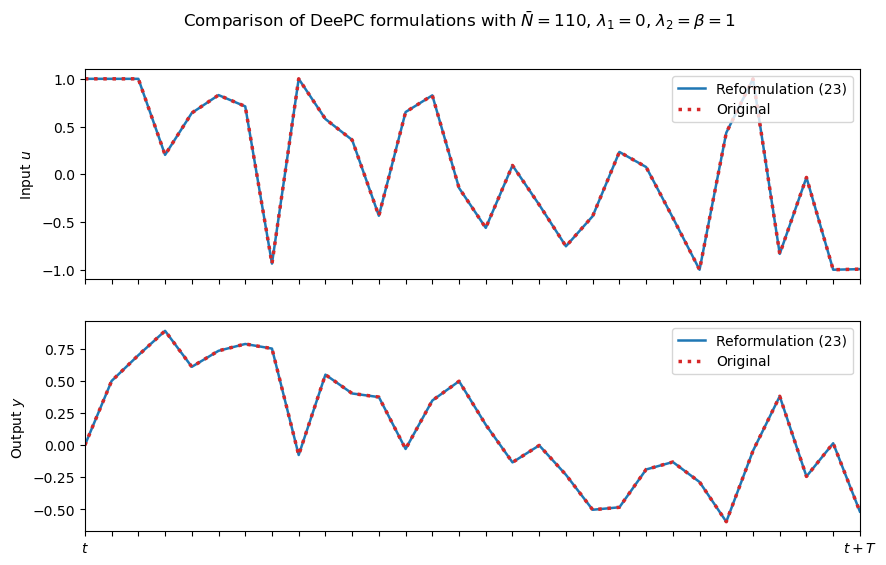

In [6]:
compare_deepc_formulations(N_bar=110, lambda2=1, random_seed=1234, reg_mode='proj')

Training set generated [N_bar = 120]. SNR = [12.01457087]
Average time for DeePC's indirect reformulation (23): 72.49 ms
Average time for DeePC's direct formulation: 65.95 ms


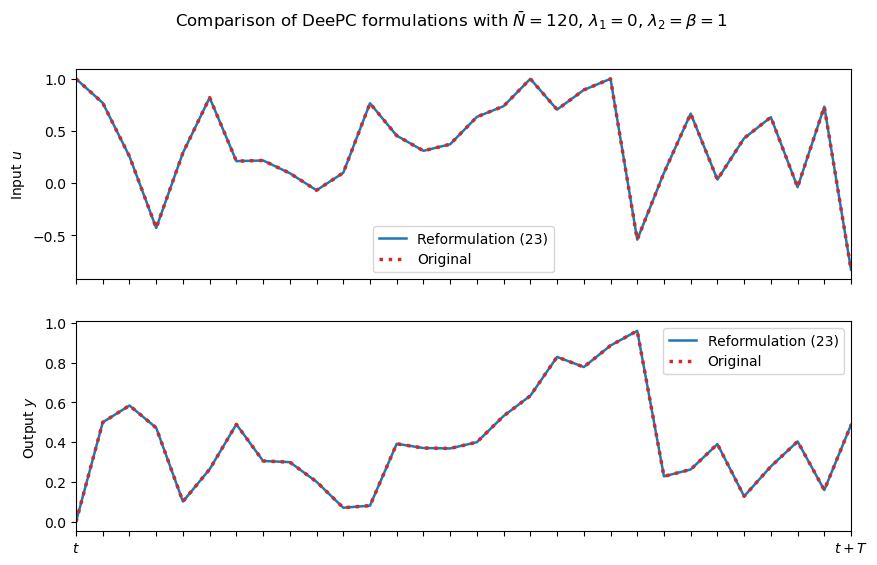

In [7]:
compare_deepc_formulations(N_bar=120, lambda2=1, random_seed=1234, reg_mode='proj')

Training set generated [N_bar = 150]. SNR = [13.34096533]
Average time for DeePC's indirect reformulation (23): 75.24 ms
Average time for DeePC's direct formulation: 77.15 ms


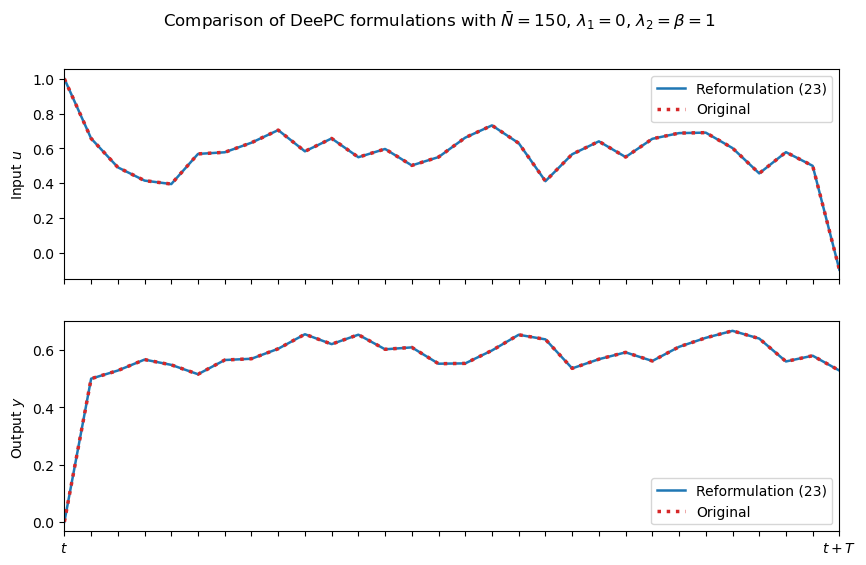

In [8]:
compare_deepc_formulations(N_bar=150, lambda2=1, random_seed=2345, reg_mode='proj')

Training set generated [N_bar = 179]. SNR = [12.41523838]
Average time for DeePC's indirect reformulation (23): 75.39 ms
Average time for DeePC's direct formulation: 86.38 ms


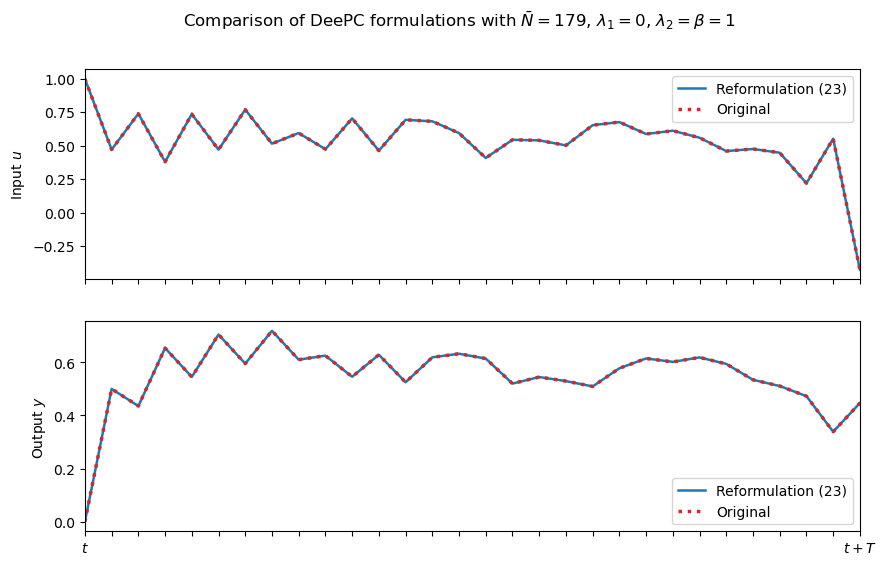

In [9]:
compare_deepc_formulations(N_bar=179, lambda2=1, random_seed=3456, reg_mode='proj')

Training set generated [N_bar = 250]. SNR = [11.41607278]
Average time for DeePC's indirect reformulation (23): 74.02 ms
Average time for DeePC's direct formulation: 126.70 ms


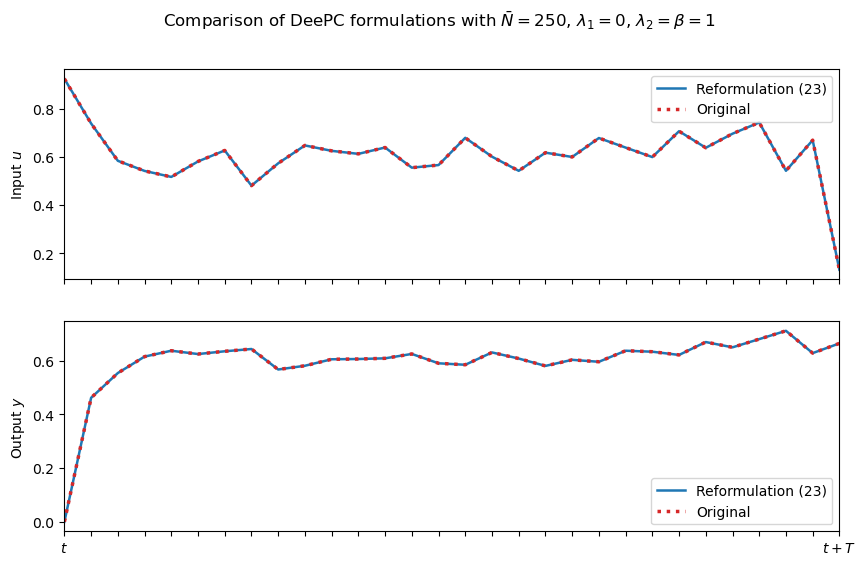

In [10]:
compare_deepc_formulations(N_bar=250, lambda2=1, random_seed=4567, reg_mode='proj')

Training set generated [N_bar = 500]. SNR = [12.15207574]
Average time for DeePC's indirect reformulation (23): 74.96 ms
Average time for DeePC's direct formulation: 381.75 ms


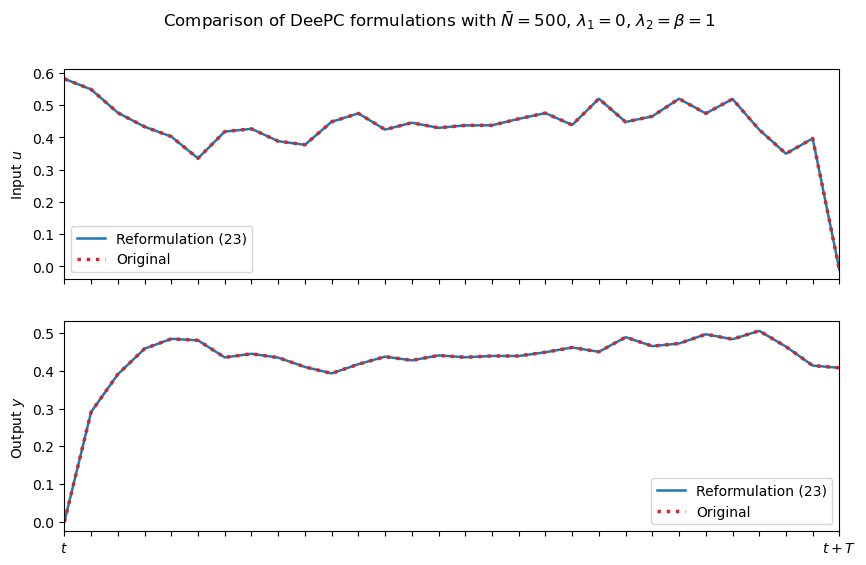

In [11]:
compare_deepc_formulations(N_bar=500, lambda2=1, random_seed=45671, reg_mode='proj')

Training set generated [N_bar = 500]. SNR = [12.75438507]
Average time for DeePC's indirect reformulation (23): 73.27 ms
Average time for DeePC's direct formulation: 390.59 ms


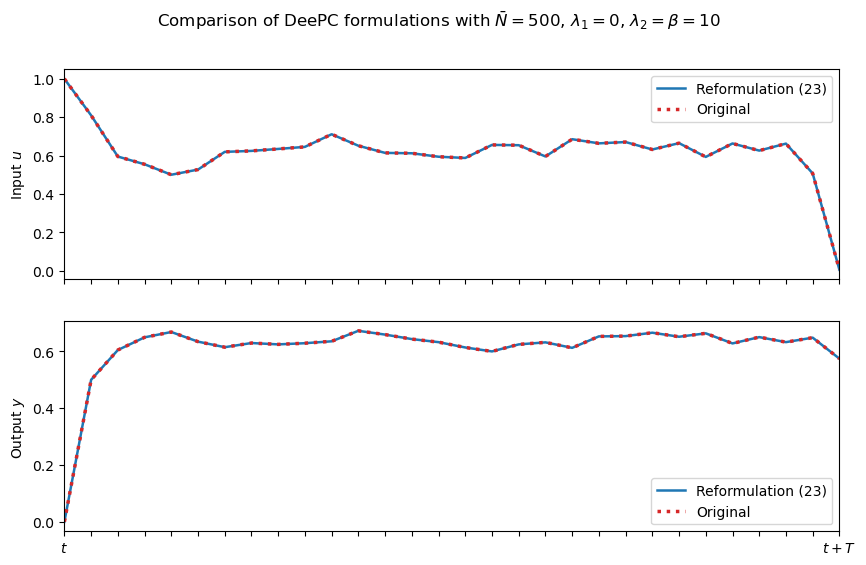

In [12]:
compare_deepc_formulations(N_bar=500, lambda2=10, random_seed=45672, reg_mode='proj')

Training set generated [N_bar = 1000]. SNR = [11.75398184]
Average time for DeePC's indirect reformulation (23): 73.00 ms
Average time for DeePC's direct formulation: 1774.46 ms


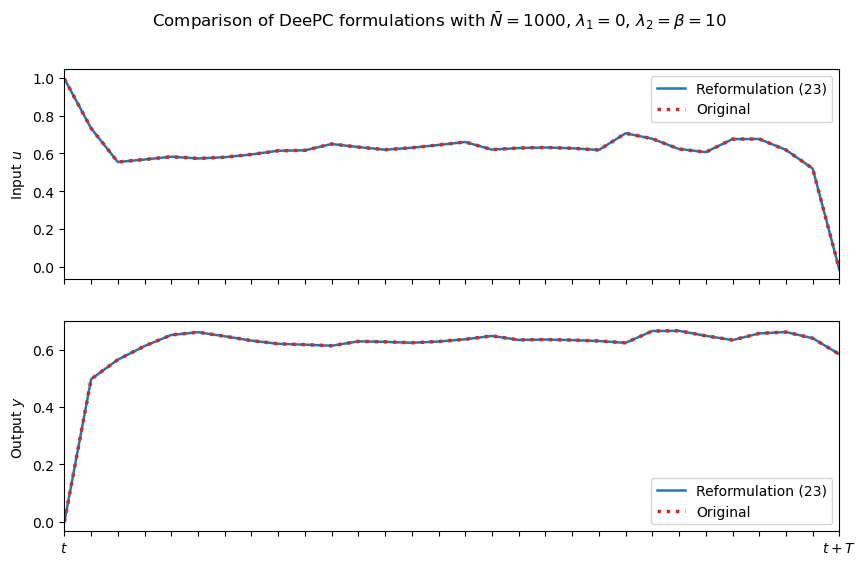

In [13]:
compare_deepc_formulations(N_bar=1000, lambda2=10, random_seed=45673, reg_mode='proj')

Training set generated [N_bar = 150]. SNR = [9.73122414]
Average time for DeePC's indirect reformulation (23): 94.08 ms
Average time for DeePC's direct formulation: 73.89 ms


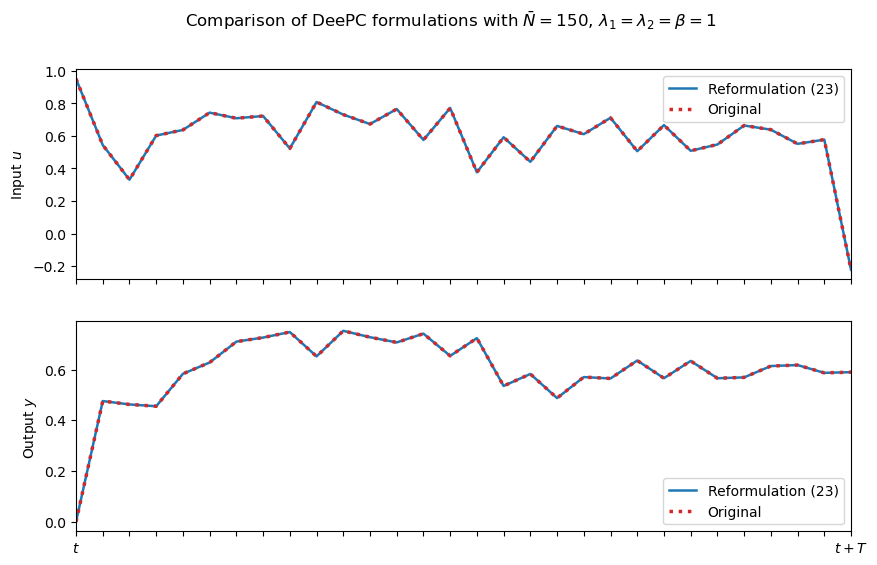

In [14]:
compare_deepc_formulations(N_bar=150, lambda2=1, random_seed=6789, reg_mode='l2')

Training set generated [N_bar = 250]. SNR = [10.30270692]
Average time for DeePC's indirect reformulation (23): 82.59 ms
Average time for DeePC's direct formulation: 94.21 ms


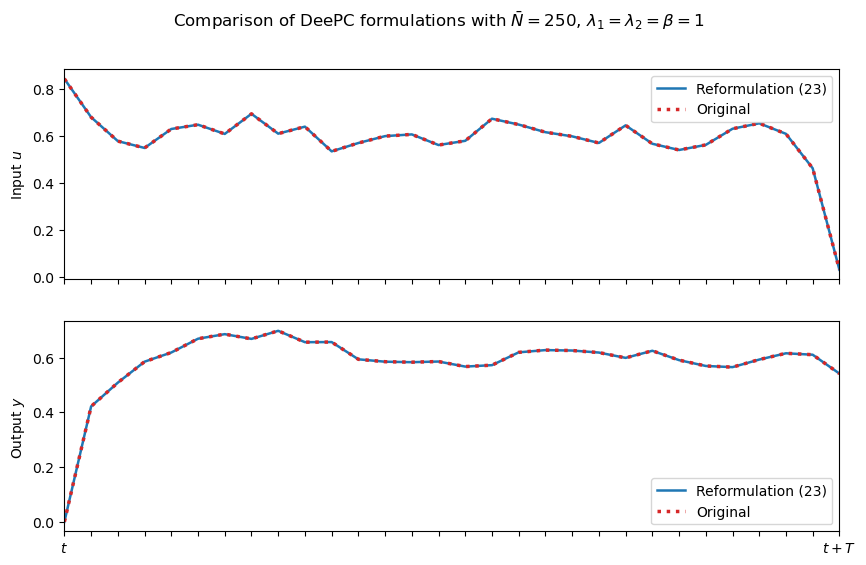

In [15]:
compare_deepc_formulations(N_bar=250, lambda2=1, random_seed=7890, reg_mode='l2')

**They are indeed equivalent!**

## Discussion of the computational time

* In low-data regimes, the two formulations require a comparable computational time. The indirect reformulation takes (approximately) 10% longer due to the range constraint $\varphi$.  
  However, more efficient ways to enforce this range constraint (e.g., the one used for the range constraint on $\Delta\hat{y}$ might boost the computational performances significantly.
* As the training data increases, the computational burden of the indirect reformulation does not change (it actually decreases as range constraints are removed), while the computational burden of the direct formulation increases significantly. 